#### In this notebook we download single day MUR data (netcdf) to a folder, then import that data, convert it to an xarray and then apply the 3 algorithms (Canny, BOA and CCA). We can also visualize the fronts in a map or save the 3 fronts and the sst image in a NetCDF file

## Import libraries

In [1]:
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib
from pathlib import Path
%matplotlib inline
from PIL import Image
from math import floor, ceil
import cv2
from PIL import Image
import pandas as pd
import wget
import datetime
from datetime import date, timedelta
from matplotlib.colors import ListedColormap
from pydap.client import open_url
import netCDF4 as nc
from scipy.ndimage import gaussian_filter

from global_land_mask import globe

plt.rcParams["figure.figsize"] = 12, 8

/home/luisfigueiredo/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Import functions to apply the BOA and CCA, which are defined in other notebooks

In [2]:
#import functions to aplly the CCA
from ipynb.fs.full.CCA_functions_xarray import getFrontInWindow
from ipynb.fs.full.CCA_functions_xarray import CCA_SIED

In [3]:
#import functions to aplly the BOA
from ipynb.fs.full.BOA_functions import boa

## Functions to Download MUR Data

In [4]:
def boundingindex(dmin, dint, boundary0, boundary1):
    """
    get boundaries values to download the data already cropped
    """
    inx0 = max(int(floor((boundary0 - dmin) / dint)), 0)
    inx1 = max(int(floor((boundary1 - dmin) / dint)), 0)
    if inx0 > inx1:
        atemp = inx0
        inx0 = inx1
        inx1 = atemp
    return [inx0, inx1]

In [5]:
def get_mur_params(lon_box, lat_box):
    """
    Check sample file to get parameters for sst
    """
    mur_ncin = open_url(
        'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/002/20180102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
    lon = mur_ncin['lon']
    lat = mur_ncin['lat']
    lon_step = np.mean(np.diff(lon))
    lat_step = np.mean(np.diff(lat))
    [mur_i0, mur_i1] = boundingindex(lon[0][0].data, lon_step, lon_box[0], lon_box[1])
    [mur_j0, mur_j1] = boundingindex(lat[0][0].data, lat_step, lat_box[0], lat_box[1])

    return mur_i0, mur_i1, mur_j0, mur_j1

In [6]:
#those are the mur_i0, mur_i1, mur_j0 and mur_j1 params for those lon_box, lat_box
get_mur_params([-19, -5], [35,45])

(16099, 17499, 12499, 13499)

In [13]:
def download_from_url(fileget, filenameout, replace, printiti):
    """
    function that tries to download data from "fileget" if the data didn't previously exist,
    the user asked to replace the old data, or the file has 0 bytes
    """
    exists = os.path.exists(filenameout)
    if exists:
        file_size = os.path.getsize(filenameout)
    else:
        file_size = 1
    if (not exists) or (replace and exists) or (file_size == 0):
        if exists:
            os.remove(filenameout)
        try:
            return wget.download(fileget, out=filenameout, bar=None)
        except Exception as e:
            if printiti:
                print(e)
                print("Error downloading")
                print("Download error url: " + fileget)
            return e
    return filenameout

In [9]:
def download_sst(path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    
    """
    Function to download a specific day of data. We need to provide 
    the path where it will be downloaded and the parameters (mur_j0, mur_j1, muri0, muri1). We can get these parameters
    with the get_mur_params function that receives as parameter the range of longitude and latitude values
    We need it for our SST data
    """
    
    opendap_dir = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/' + str(
        date.year) + '/'
    filename = opendap_dir + "{0:0>3}".format(str(date.dayofyear)) + '/' + date.strftime(
        "%Y%m%d") + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4'
    filenameout = path + "sst_" + date.strftime("%Y%m%d") + '.nc'
    fileget = filename + '?analysed_sst[0:1:0][' + str(mur_j0) + ':1:' + str(mur_j1) + '][' + str(mur_i0) + ':1:' + str(
        mur_i1) + ']'
    download_from_url(fileget, filenameout, replace, 1)
    return

In [10]:
def download_sst_thread(data_range, sst_path, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    
    """
    Function to download several days of data simultaneously. We just need to provide the data_range,
    the path where it will be downloaded and the parameters (mur_j0, mur_j1, muri0, muri1). We can get these parameters
    with the get_mur_params function that receives as parameter the range of longitude and latitude values
    We need it for our SST data
    """
    
    for date in tqdm(data_range, desc='SST', file=sys.stdout):
        download_sst(sst_path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace)
    return

### Download MUR daily data

In [11]:
def download_daily_mur(day_txt):
    
    """
    Function to download MUR data to a folder called MUR_daily_data in the data folder.
    day_txt (string) its the day of MUR data we want to download. It's in the format ('%Y%m%d')
    The values mur_jo, mur_j1, mur_i0, mur_i1 are regarding the coordinate values we want. One can discover them 
    thanks to the get_mur_params function
    """
    
    base_path = os.getcwd()
    base_path = os.path.join(base_path, '../data')
    
    
    exist_path = os.path.exists(os.path.join(base_path, 'MUR_daily_data'))   #check if folder MUR_daily_data exists in data folder
    if not exist_path:                                                            #if it don't exist:
        os.makedirs(os.path.join(base_path, 'MUR_daily_data'))  
        
        
    download_sst(path = os.path.join(base_path, 'MUR_daily_data/'), date = pd.to_datetime(day_txt), mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

In [14]:
download_daily_mur('20221225')

## Import Data
We are going to import the data from the NetCDF and convert it to an xarray

In [15]:
def get_data(filename):
    
    """
    Function to get our netCDF file that is stored in the data directory inside the MUR_daily_data folder
    and convert it to an xarray.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    base_path = os.path.join(base_path, '../data/MUR_daily_data')
    
    nc_path = os.path.join(base_path, filename)
    data_xarray = xr.load_dataset(nc_path)
    
    #Convert temperature from Kelvin to Celsius
    data_xarray['analysed_sst'] = data_xarray['analysed_sst'] - 273.15
    
    return data_xarray


In [16]:
# Import data and convert it to an xarray
xarray_mur = get_data('sst_20221225.nc')

#### Function to visualize the front in a map

In [ ]:
def front_visualization(front_array, data_xarray):
    
    """
    Function to visualize the map of the front.
    We use the sst data "analysed_sst" to create a mask for the continental zone
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = front_array.copy()
    # replace NaNs with 0s
    fp = np.nan_to_num(fp, nan=0)
    fp = np.flip(fp, axis=0)  #flip along the horizontl axis
    
    df = data_xarray.to_dataframe().reset_index()
    #Create a mask for our continental zone
    sst = df.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 1)
    newcolor = viridis(np.linspace(0,1,10))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(np.unique(data_xarray['lat'].values))
    lon = np.array(np.unique(data_xarray['lon'].values))

    plt.imshow(fp, cmap=newcmp, extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.title("Front (MUR) ", fontsize=20)

## -------------------------------------------- Canny Algorithm ------------------------------------------------

In [17]:

def canny_front_detection_1day(data_xarray, thresh_min=120, thresh_max=220, apertureSize=5, sigma=5):
    
    """
    This function receives an xarray with MUR data for a individual day and returns the array 
    that result from the aplication of the Canny Algorithm from OpenCV. 
    One can change the minimum and maximum threshold, the apertureSize.
    One can also apply a gaussian filter with a certain sigma value to reduce noise of the image.
    """
    
    #Get the sst array in the right shape
    sst = data_xarray['analysed_sst'][0,:,:].values
    #Convert Temperature values to uint8 format with values in the range of 0-255
    sst_final = ((sst - np.nanmin(sst)) * (1/(np.nanmax(sst) - np.nanmin(sst)) * 255)).astype('uint8')
    sst_final = np.flipud(sst_final)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    #in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
    sst_final = gaussian_filter(sst_final, sigma=sigma)   
    
    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(sst_final, thresh_min, thresh_max, apertureSize=apertureSize, L2gradient=False)
    
    canny[canny == 255] = 1
    
    #convert 0s to Nans
    canny = canny.astype('float')
    canny[canny == 0] = 'nan'
    
    canny_front = np.flipud(canny)   
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    
    # Lat/lon points to get
    lat = np.linspace(lat_min,lat_max,lat_dims)
    lon = np.linspace(lon_min,lon_max,lon_dims)
    # Make a grid
    lon_grid, lat_grid = np.meshgrid(lon,lat)
    # Get whether the points are on land.
    z = globe.is_land(lat_grid, lon_grid)
    canny_front[z == True] = np.nan
    
    
    return canny_front

In [18]:
canny_f = canny_front_detection_1day(xarray_mur)

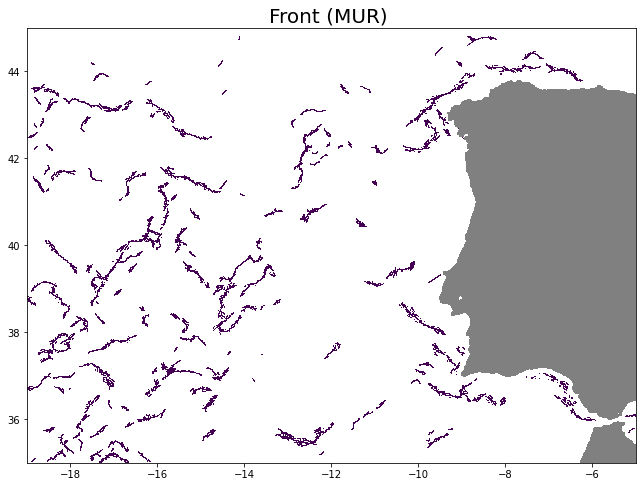

In [20]:
front_visualization(canny_f, xarray_mur)

## -------------------------------- Belkin O'Reilly Algorithm (BOA) -----------------------------------------

In [21]:

def BOA_aplication(data_xarray, threshold = 0.05):  
    
    """
    Function to, for a given dataframe with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise don't). 
    """
    
    lon = np.array(data_xarray['lon']).astype('float64')
    lat = np.array(data_xarray['lat']).astype('float64')
    
    ingrid = data_xarray['analysed_sst'][0,:,:].values    
    
    boa_front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    boa_front = np.flip(boa_front, axis=0)
    boa_front = np.array([[boa_front[j][i] for j in range(len(boa_front))] for i in range(len(boa_front[0])-1,-1,-1)])
    
    boa_front = np.where(boa_front>=threshold, 1, boa_front)    
    boa_front = np.where(boa_front<threshold, 0, boa_front)
    
    #convert 0s to Nans
    boa_front[boa_front == 0] = 'nan'
    
    boa_front = np.flipud(boa_front) 

    return boa_front


In [22]:
boa_f = BOA_aplication(xarray_mur, threshold=0.05)

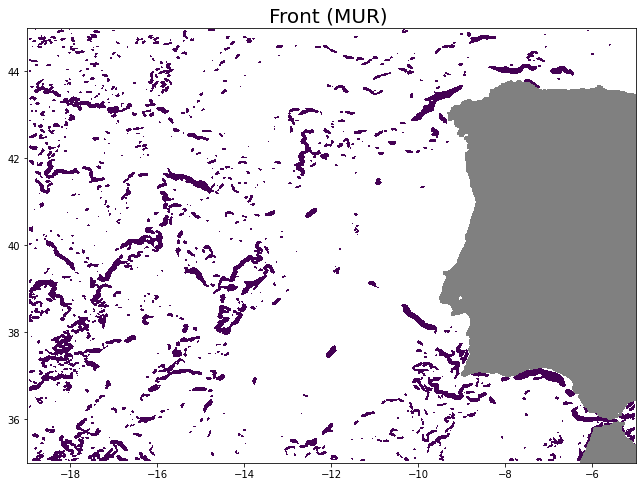

In [23]:
front_visualization(boa_f, xarray_mur)

## ---------------------------------- Cayula-Cornillon Algorithm (CCA) ------------------------------------

In [24]:
    
def CCA_front(data_xarray): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    """
    
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    div_rows = (lat_max-lat_min)/lat_dims
    div_cols = (lon_max-lon_min)/lon_dims
    
    
    front = np.zeros((lat_dims,lon_dims))       #initialize a matrix of zeros. This shape is for the MUR data
    
    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
        
    xdata_final, ydata_final = CCA_SIED(data_xarray)       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
        
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (-lon_min+value)/div_cols                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (lat_max-value)/div_rows                  #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)
     
    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
            
    front[front != 0] = 1
    
    #convert 0s to Nans
    front[front == 0] = 'nan'

    cca_front = np.flipud(front) 
    
    
    return cca_front

/home/luisfigueiredo/JUNO/notebooks/CCA_functions_xarray.ipynb:79: RuntimeWarning: invalid value encountered in double_scalars
  "    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise\n",
/home/luisfigueiredo/JUNO/notebooks/CCA_functions_xarray.ipynb:177: UserWarning: No contour levels were found within the data range.
  "                if (w[row, col+1] <= thresValue):               #if right pixel < separation\n",


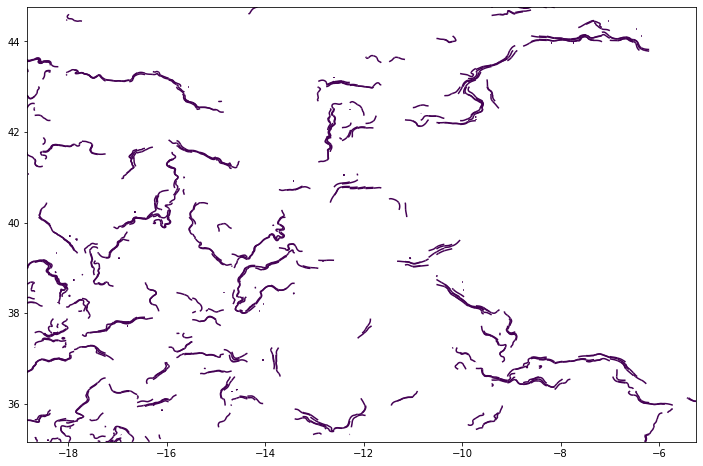

In [26]:
cca_f = CCA_front(xarray_mur)

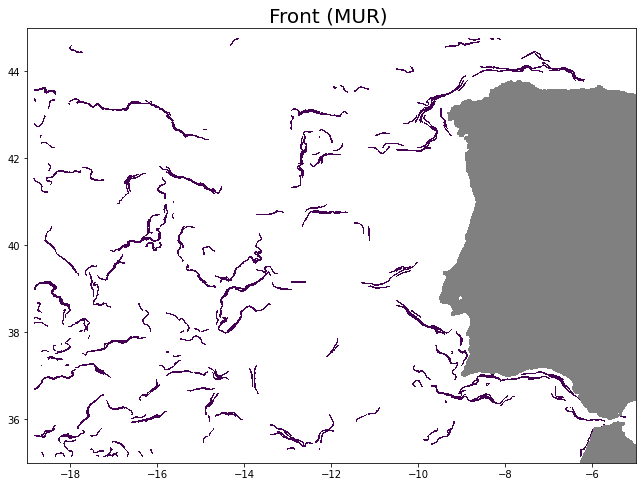

In [27]:
front_visualization(cca_f, xarray_mur)

## -------------------------------------------- Real SST Image --------------------------------------------------

In [28]:
def real_sst_image(data_xarray):
        
    """
    Function to return the real sst image as an array
    """
    
    sst_image = data_xarray['analysed_sst'][0,:,:].values
    
    return sst_image

In [31]:
sst_image = real_sst_image(xarray_mur)

In [34]:
def sst_visualization(front_array, data_xarray):
    
    """
    Function to visualize the map the SST data.
    We use the sst data "analysed_sst" to create a mask for the continental zone.
    """
    
    #first we apply the frontal_prob function to a certain period of data
    fp = front_array.copy()
    fp = np.flip(fp, axis=0)  #flip along the horizontl axis
    
    df = data_xarray.to_dataframe().reset_index()
    #Create a mask for our continental zone
    sst = df.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(np.unique(data_xarray['lat'].values))
    lon = np.array(np.unique(data_xarray['lon'].values))

    plt.imshow(fp, cmap='viridis', extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.title("SST (MUR) ", fontsize=20)

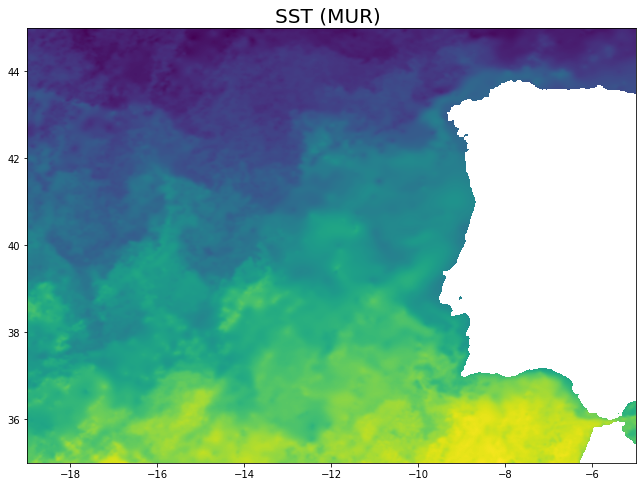

In [35]:
sst_visualization(sst_image, xarray_mur)

## -------------------------------------- Save results in NetCDF ---------------------------------------------

In [36]:
day_txt = '20221225'

In [37]:

base_path = os.getcwd()
base_path = os.path.join(base_path, '../data')

#Check if exists a folder to save the netcdf. If not create the folder
exist_path = os.path.exists(os.path.join(base_path, 'MUR_daily_fronts_netcdf'))    
if not exist_path:                                                                         
    os.makedirs(os.path.join(base_path, 'MUR_daily_fronts_netcdf'))                


In [38]:

def fronts_2_netcdf(data_xarray, day_txt, sst_image, canny_f, boa_f, cca_f):
    
    """
    File to save the 4 arrays (canny, BOA, CCA, SST) as NetCDFs. This arrays are regarding a specific day so we
    don't need to have a time variable (either way it can be add this variable if one pleases)
    day_txt is a string in the format Y%m%d
    """
    
    lat_dims = data_xarray.dims['lat']
    lon_dims = data_xarray.dims['lon']
    
    lat_max = data_xarray['lat'].values.max()
    lat_min = data_xarray['lat'].values.min()
    lon_max = data_xarray['lon'].values.max()
    lon_min = data_xarray['lon'].values.min()
    
    nc_file = os.getcwd()
    nc_file = os.path.join(nc_file, '../data/MUR_daily_fronts_netcdf/MUR_' + day_txt + '.nc')

    ds = nc.Dataset(nc_file, 'w', format='NETCDF4')

    ds.title = 'MUR ' + day_txt + ' Fronts Arrays (Xarrays)'

    #create dimensions of the NetCDF file
    lat = ds.createDimension('lat', lat_dims)
    lon = ds.createDimension('lon', lon_dims)

    lats = ds.createVariable('lat', 'f4', ('lat', ))
    lons = ds.createVariable('lon', 'f4', ('lon', ))

    sst_analyzed = ds.createVariable('sst', 'f4', ('lat', 'lon',))    #('time', 'lat', 'lon',)
    sst_analyzed.units = 'C'   #degrees Celsius
    sst_analyzed.description = 'Array with the Sea-Surface Temperature (SST) relative to the MUR data for that day'
    sst_analyzed[:, :] = sst_image


    canny = ds.createVariable('Canny', 'f4', ('lat', 'lon',))
    canny.units = 'Unknown'
    canny.description = 'Binary Array with identyfied fronts through Canny from OpenCV (1-> front), (0->not front)'
    canny[:, :] = canny_f.astype(float)

    boa = ds.createVariable('BOA', 'f4', ('lat', 'lon',))
    boa.units = 'Unknown'
    boa.description = 'Binary Array with identyfied fronts through the Belkin O Reilly Algorithm (temperature gradient). If the gradient is bigger than certain threshold is considered front (1) otherwise 0'
    boa[:, :] = boa_f

    cca = ds.createVariable('CCA', 'f4', ('lat', 'lon',))
    cca.units = 'Unknown'
    cca.description = 'Binary Array with identyfied fronts through the Cayula Cornillon Algorithm (1->front) (0->not front)'
    cca[:, :] = cca_f.astype(float)


    lats[:] = np.linspace(lat_min, lat_max, lat_dims)
    lons[:] = np.linspace(lon_min, lon_max, lon_dims)

    ds.close()



In [39]:
fronts_2_netcdf(xarray_mur, '20221225', sst_image, canny_f, boa_f, cca_f )